# Effect size

The significance test will give you an idea of whether the observed data is likely to have come from a distribution where there is no difference.

$$P(\text{Data}|\text{Null distribution})$$

- A low p-value suggests that the observed data is less likely to come from a null distribution and the differences we observe may not be due to random chance
- However, a low p-value does _not_ tell us the magnitude of the difference observed (effect size) e.g whether a decrease in cholesterol is small or large

To get an idea of how big of an change is observed, we can look at the 
**effect size**, which can be expressed as a raw  or standardized statistic
 - ```raw```: absolute difference between groups (e.g. difference of means)
 - ```standardized```: ratio of the difference between groups and the noise/variation
 
The standardized effect size can be thought of as a a ratio of the signal (e.g. real differences) to noise (e.g. unaccounted variation)


$$ \text{Standardized effect size} = \frac{\mathit{signal}}{\mathit{noise}}$$

There are different measures of effect sizes, depending on what is being compared. 
- Shown below are some examples of `raw` and `standardized` effect sizes. 
- We will explore these different standardized effect sizes for the different hypothesis tests

![effect_size.png](images/effect_size.png)

---
## Data preparation

To get an intuition of effect sizes, we will use the  diet/cholesterol dataset to demonstrate the concept of effect sizes for **continuous** variables in a simple case comparing continuous values (cholesterol levels) in 2 different diet groups (cornflakes and oatbran)

https://myweb.uiowa.edu/pbreheny/data/oatbran.html

In [1]:
library(tidyverse)

data <- read_tsv("https://raw.githubusercontent.com/kennethban/dataset/main/oatbran.tsv")

data_grouped <- data %>% 
                gather(CornFlakes, OatBran, key="treatment", value="effect") %>%
                mutate(treatment=as.factor(treatment))

head(data_grouped)
tail(data_grouped)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 14 Columns: 2

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (2): CornFlakes, OatBran


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



treatment,effect
<fct>,<dbl>
CornFlakes,4.61
CornFlakes,6.42
CornFlakes,5.40
CornFlakes,4.54
CornFlakes,3.98
CornFlakes,3.82


treatment,effect
<fct>,<dbl>
OatBran,3.49
OatBran,3.84
OatBran,5.26
OatBran,3.73
OatBran,1.84
OatBran,4.14


We will plot the values to see how they differ between the 2 dietary groups

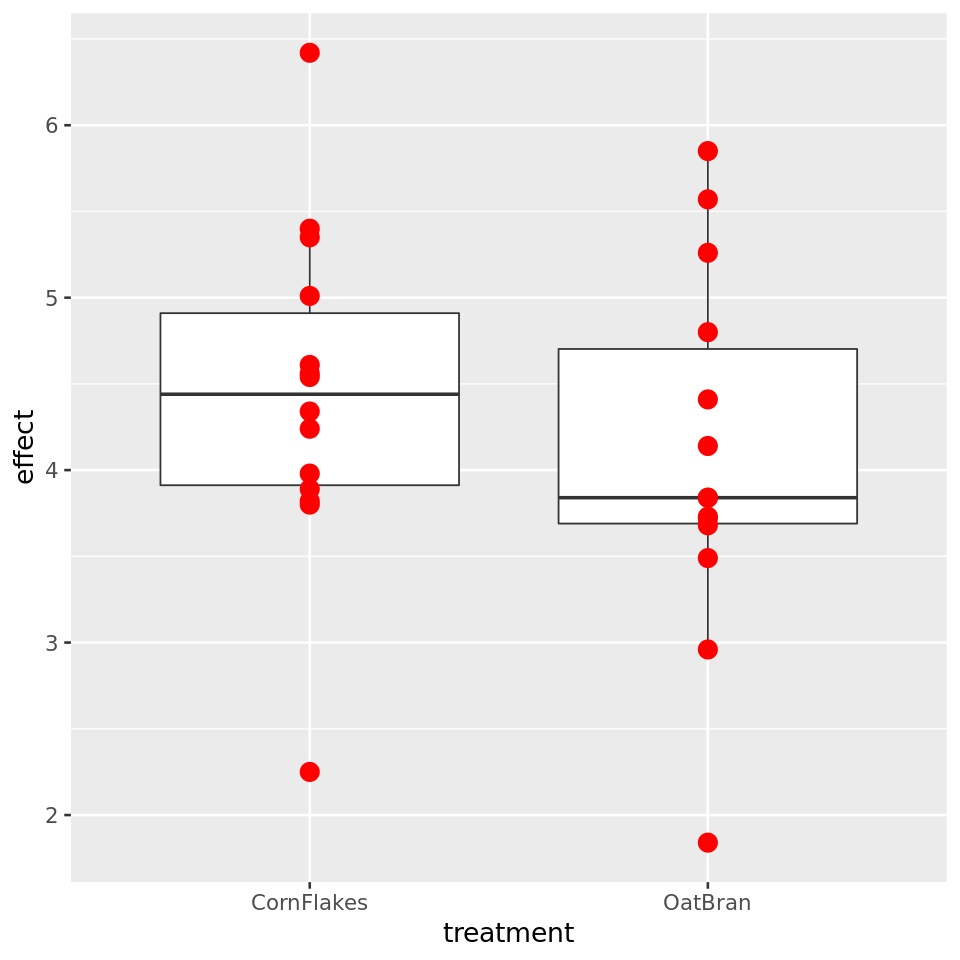

In [47]:
# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

data_grouped %>% 
ggplot(aes(x=treatment, y=effect)) +
  geom_boxplot() +
  geom_point(color="red", size=5) +
  theme_grey(base_size=16)

### 1. Raw effect size

The simplest way is to find the difference of means between the 2 groups. In this case, we calculate the means of each group then we find the difference of the means

```
difference of means = abs(mean group 1 - mean group 2)
```

In [48]:
data_grouped %>% 
group_by(treatment) %>% 
summarize(mean = mean(effect)) %>% 
summarize(raw_effect = abs(diff(mean)))

raw_effect
<dbl>
0.3628571


We can also obtain the 95% confidence interval for this difference of means using a function from the `rstatix` library

In [49]:
data_grouped %>% 
rstatix::t_test(effect ~ treatment, 
                detailed = T) %>% 
select(conf.low, conf.high) 

conf.low,conf.high
<dbl>,<dbl>
-0.4251218,1.150836


### 2. Standardized effect size

To standardize the effect size for the 2 groups, we can estimate the signal to noise ratio, which is the difference of means divided by the combined variation in both groups. This known as _Cohen's d_ statistic

For independent samples:

$$ \text{Standardized effect size} = \frac{\mathit{signal}}{\mathit{noise}} = \frac{\mu_1 - \mu_2}{\sqrt{\frac{sd
_1 + sd_2}{2}}}$$

We can use the `cohens_d` function from the `effectsize` library to calculate the  _Cohen's d_ statistic for the effect size of means between 2 groups and the uncertainty in the estimate (95% CI)

In [51]:
effectsize::cohens_d(effect ~ treatment, 
                     data = data_grouped)

Cohens_d,CI,CI_low,CI_high
<dbl>,<dbl>,<dbl>,<dbl>
0.3578947,0.95,-0.3925678,1.101621


To get sense of the magnitude of the effect size, we can pass the `Cohens_d` value to the `interpret_d` function

In [54]:
effectsize::cohens_d(effect ~ treatment, 
                     data = data_grouped) %>% 
pull(Cohens_d) %>% 
effectsize::interpret_cohens_d()

[1] "small"
(Rules: cohen1988)


### How does the signal and noise affect the effect size?

To see how the size of the signal (difference of means) and the noise (variation in the values) affects the standardized effect size, we will simulate normally distributed values of 2 groups with a range of differences and variations in the values

In [55]:
effect_size <- function(n, mean_1, mean_2, sd_1, sd_2) {
    
    simulation <- tibble(normal=rnorm(n,mean_1, sd_1), diet=rnorm(n,mean_2, sd_2)) %>% 
              pivot_longer(cols=c("normal","diet"), names_to = "group", values_to = "glucose") %>%
              mutate(group = as.factor(group))
        
    es <- effectsize::cohens_d(glucose ~ group, data=simulation) %>% 
          pull(Cohens_d) %>%
          abs %>% round(2)
    
    interpretation <- effectsize::interpret_cohens_d(es)
    
    text <- glue::glue("d: {es} size: {interpretation}")
    
    plot <- simulation %>% ggplot(aes(x=glucose, fill=group)) + 
            geom_density(alpha=0.5) + 
            ggtitle(text)
    
    return(plot)
   
}

We can plot the distributions and compare how the difference of means and the degree of variation affects the standardized effect sizes


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




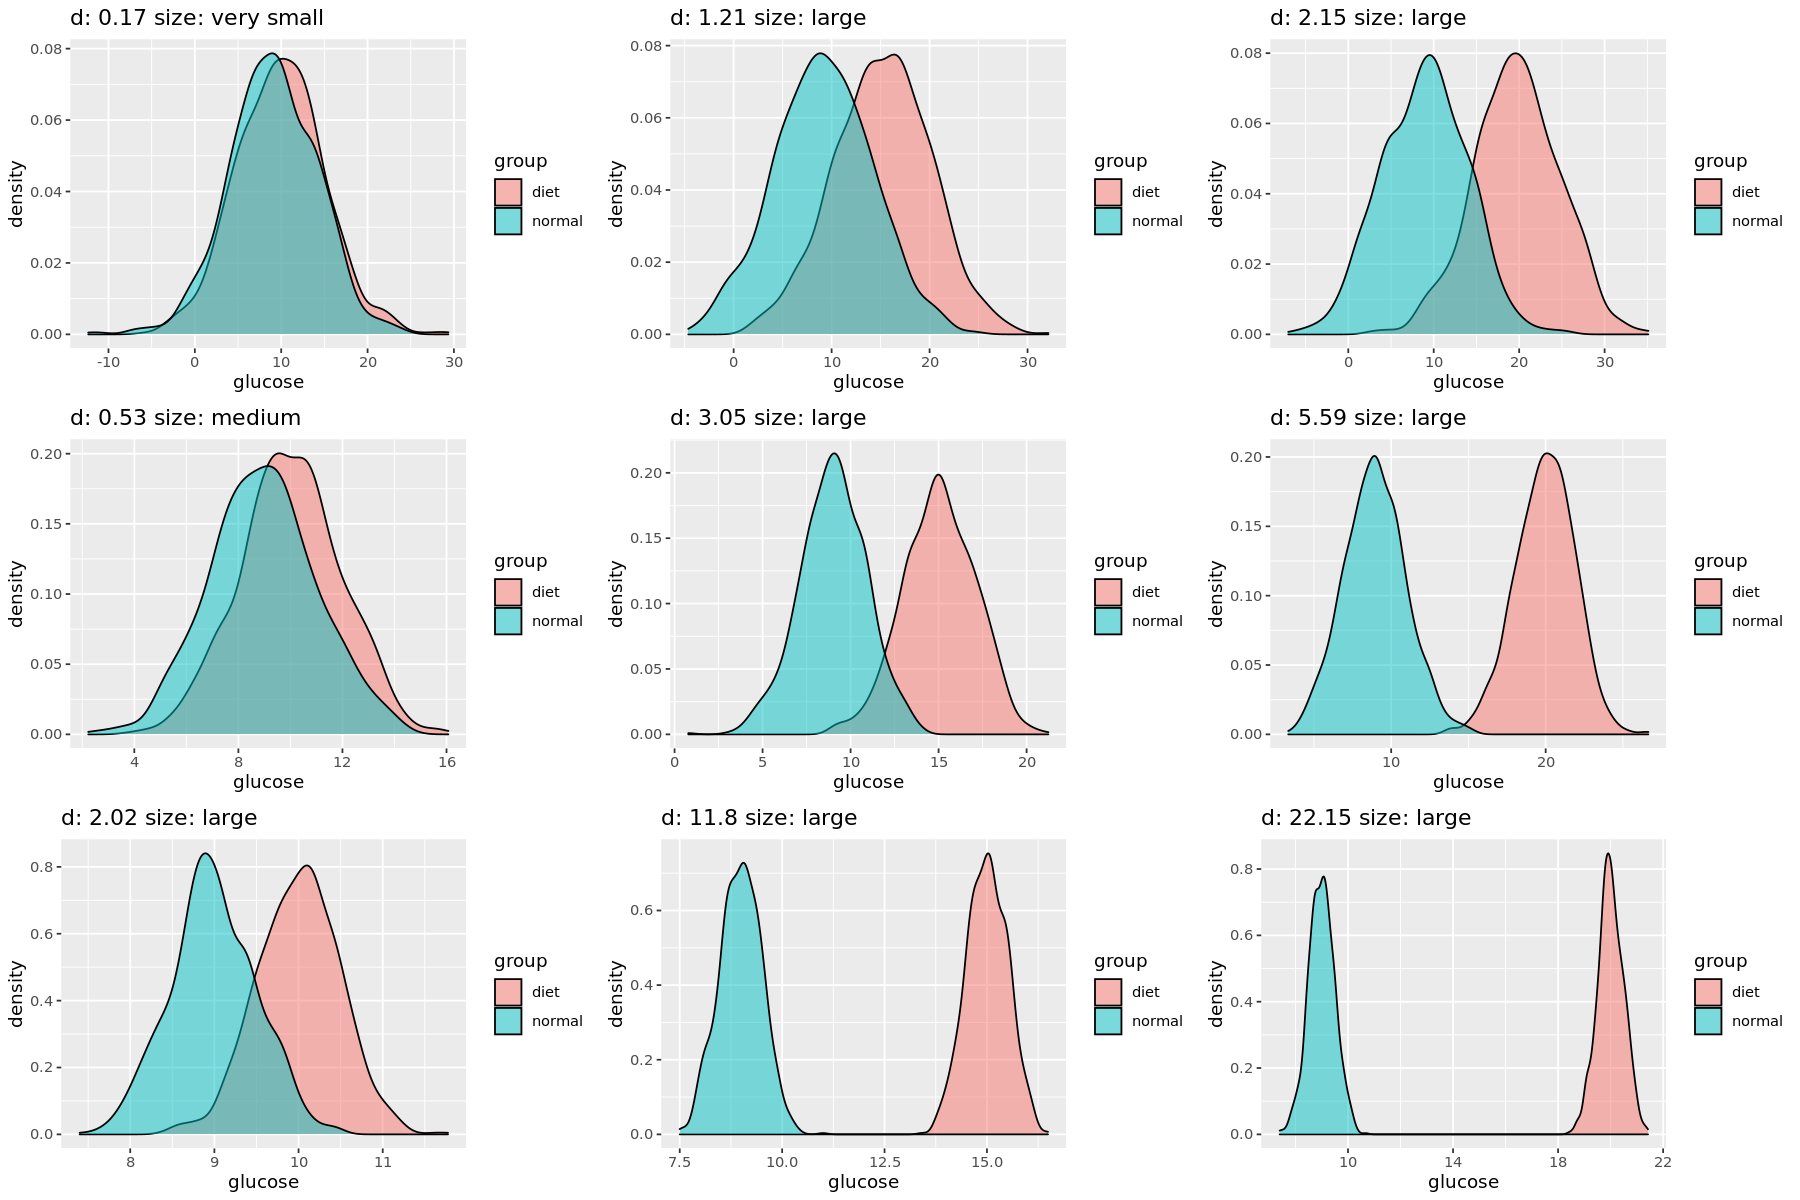

In [56]:
# plot a grid of different signal and noise combinations
library(gridExtra)

# adjust size of the image output
options(repr.plot.width=15, repr.plot.height=10)

# plot a grid of distributions
# the signal (difference of means) increases from left to right
# the noise (standard deviation) decreases from top to bottom

grid.arrange(
effect_size(n=1000, mean_1=9, mean_2=10, sd_1=5, sd_2=5),
effect_size(n=1000, mean_1=9, mean_2=15, sd_1=5, sd_2=5),
effect_size(n=1000, mean_1=9, mean_2=20, sd_1=5, sd_2=5),
effect_size(n=1000, mean_1=9, mean_2=10, sd_1=2, sd_2=2),
effect_size(n=1000, mean_1=9, mean_2=15, sd_1=2, sd_2=2),
effect_size(n=1000, mean_1=9, mean_2=20, sd_1=2, sd_2=2),   
effect_size(n=1000, mean_1=9, mean_2=10, sd_1=0.5, sd_2=0.5),
effect_size(n=1000, mean_1=9, mean_2=15, sd_1=0.5, sd_2=0.5),
effect_size(n=1000, mean_1=9, mean_2=20, sd_1=0.5, sd_2=0.5),
ncol=3)



We can see that as the noise decreases, the standardized effect size increases